# Importing packages

In [1]:
import os
starting_directory = os.getcwd()
print(os.getcwd())

new_dirrectory = '/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma'
os.chdir(new_dirrectory)

/blue/ferrallm/mcremer/cardiac-amyloidosis/026_SVM_mistic2


In [2]:
import sys
# sys.path.append('/Users/c.kieslich/Box Sync/Research/featureSelection/')

from mistic.svmSet import svmSet
from mistic.cvSet import cvSet 
from mistic.utility import combined_rank, kernelWrapper, score_svc, perDiff, paramSet

import matplotlib.pyplot as plt   
import numpy as np
import pandas as pd
import copy

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [3]:
import pickle

In [4]:
#some functions I wrote to help with exporting data
def outputToExcel(df_data, fileName_header, fileName_Common, fileName_suffix,
                  parent_dir, folderName, sheetName):
    fileName = fileName_header + fileName_Common + fileName_suffix
    outfile_extension = '.xlsx'
    outfile_boxplts = fileName + outfile_extension
    path_out= os.path.join(parent_dir, folderName, outfile_boxplts)

    if os.path.exists(path_out):
            #if old sheet
            with pd.ExcelWriter(path_out, mode = 'a', if_sheet_exists = 'overlay') as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True)
    else: 
            #new sheet
            with pd.ExcelWriter(path_out) as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True) #if new sheet
    
def outputFiguresPath(fileName_header, fileName_mid, fileName_suff, parent_dir, folderName):
        fileName_header = str(fileName_header)
        fileName_mid = str(fileName_mid)
        fileName_suff = str(fileName_suff)

        #cleaning the input to prevent addition of / to the directory
        fileName_header = fileName_header.replace("/", "-")
        fileName_mid = fileName_mid.replace("/", "-")
        fileName_suff = fileName_suff.replace("/", "-")

        fileName = fileName_header + fileName_mid +fileName_suff
        out_filename = fileName + '.tif'
        new_filepath = os.path.join(parent_dir, folderName, out_filename)
        #the output path can be used to save the figure
        return new_filepath
        # plt.savefig(new_filepath, bbox_inches = 'tight')

def makeFolderPathForData(parent_dir, folderName_header, folderName_common, folderName_suffix):
    #makes a new directory for your files
    #returns the folder name for use in other functions
    folderName = folderName_header + folderName_common + folderName_suffix
    path = os.path.join(parent_dir,folderName)
    if not os.path.exists(path):
        os.mkdir(path)
    return folderName

# directory management

In [5]:
# this is written to work out of the blue folder on hpg 

#for file outputs
fileName_header = "Mistic2_EchoAdj_" #what data did you put in
fileName_common = "_time-comp" #what was performed on the data, for figures, this may be added to
fileName_suffix = "_241115_v1" #date and versioning

saving_dirrectory = "012 Processed Data"
makingFolder = makeFolderPathForData(parent_dir= saving_dirrectory, folderName_header= "Mistic2_EchoAdj_", folderName_common= "241115", 
                                     folderName_suffix= "v1")
dataFrameFolderOut =  makingFolder #"SVM_Mistic_Output_2024-07-19_v2"
pickleFolderOut = makingFolder

figDirectory = "012 Processed Data"
figFolder = makingFolder 


In [6]:
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300

In [7]:
#parameters of SVM 
red_factor = 0.05

#cross validation and splitting 
test_size_numb = 1/5
numb_sets = 5

C_range = [2**x for x in range(-2,5)]
gamma_range = [2**x for x in range(-9,1)]


kernel_type = "rbf"

rank_weights = [0,0.25,0.50,0.75,1]

# importing our data

In [8]:
dataFileName = "AL-KnownPts_EchoAdj_exG01J01-time-comp_1Sheet_20241024_v1.xlsx"

In [9]:
# Import dataset
dataTable = pd.read_excel(dataFileName, header = 0) #the dataset we are using

# Setting up classifier

## Scaling data and defining test set

In [10]:
#columns to drop from the x data (samples and features)
x_columns_toDrop = ['DeID', 'Amyloid Status_yes', 'Amyloid Status_no', "Amyloid Status_unk"]


#columns to use for the y data 
y_column_Classification = 'Amyloid Status_yes'

In [11]:
X = dataTable.copy()
X.drop(columns=x_columns_toDrop,inplace=True)
scaler = StandardScaler()
scaler.fit(X)

X_all = scaler.transform(X)
y_all = dataTable[y_column_Classification]

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    stratify = y_all, 
                                                    random_state= 0, 
                                                    test_size= test_size_numb)

## define cross validation

In [12]:
cv_set = cvSet(X = X_train, y = y_train.values)
cv_set.classification(num_sets = numb_sets)

## initiallize SVC and parameter grids

In [13]:
svc = SVC(kernel = 'precomputed', class_weight="balanced", probability=False, tol = 1e-12)


parameter_grid = []
for cost in C_range:
    for gamma in gamma_range:
        parameter_grid.append(paramSet(model={"C": cost},kernel={"gamma": gamma}))

# feature selection

In [14]:

svm_set_ranks = []
for i in range(len(rank_weights)):
    print(f"Rank weight: {rank_weights[i]:.2f}")
    svm_set_ranks.append(svmSet(svc, cv_set,
                                score_method = score_svc().score,
                                kernel = kernelWrapper(type = kernel_type),
                                separate_feature_sets = False,
                                separate_parameters = False))

    svm_set_ranks[i].greedy_backward_selection(parameter_grid = parameter_grid,
                                           reduction_factor = red_factor,
                                           feature_ranker = combined_rank(weight=rank_weights[i]).compute,
                                           set_for_rank = "sample")

Rank weight: 0.00
Number of Features: 55, Score: 0.678
Number of Features: 52, Score: 0.667
Number of Features: 49, Score: 0.689
Number of Features: 46, Score: 0.711
Number of Features: 43, Score: 0.719
Number of Features: 40, Score: 0.644
Number of Features: 37, Score: 0.667
Number of Features: 35, Score: 0.633
Number of Features: 33, Score: 0.633
Number of Features: 31, Score: 0.633
Number of Features: 29, Score: 0.667
Number of Features: 27, Score: 0.678
Number of Features: 25, Score: 0.678
Number of Features: 23, Score: 0.694
Number of Features: 21, Score: 0.717
Number of Features: 19, Score: 0.736
Number of Features: 18, Score: 0.747
Number of Features: 17, Score: 0.736
Number of Features: 16, Score: 0.761
Number of Features: 15, Score: 0.740
Number of Features: 14, Score: 0.740
Number of Features: 13, Score: 0.753
Number of Features: 12, Score: 0.744
Number of Features: 11, Score: 0.737
Number of Features: 10, Score: 0.774
Number of Features: 9, Score: 0.782
Number of Features: 8

In [15]:
# add pickling stage here so that you can use this data for easy replotting

#if not already pickled use this block
pickle_file_name = 'svmsetsPickle_' + fileName_header + fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'wb')
pickle.dump(svm_set_ranks, pickle_file)



# Performance plots

## F1 and AUC plots

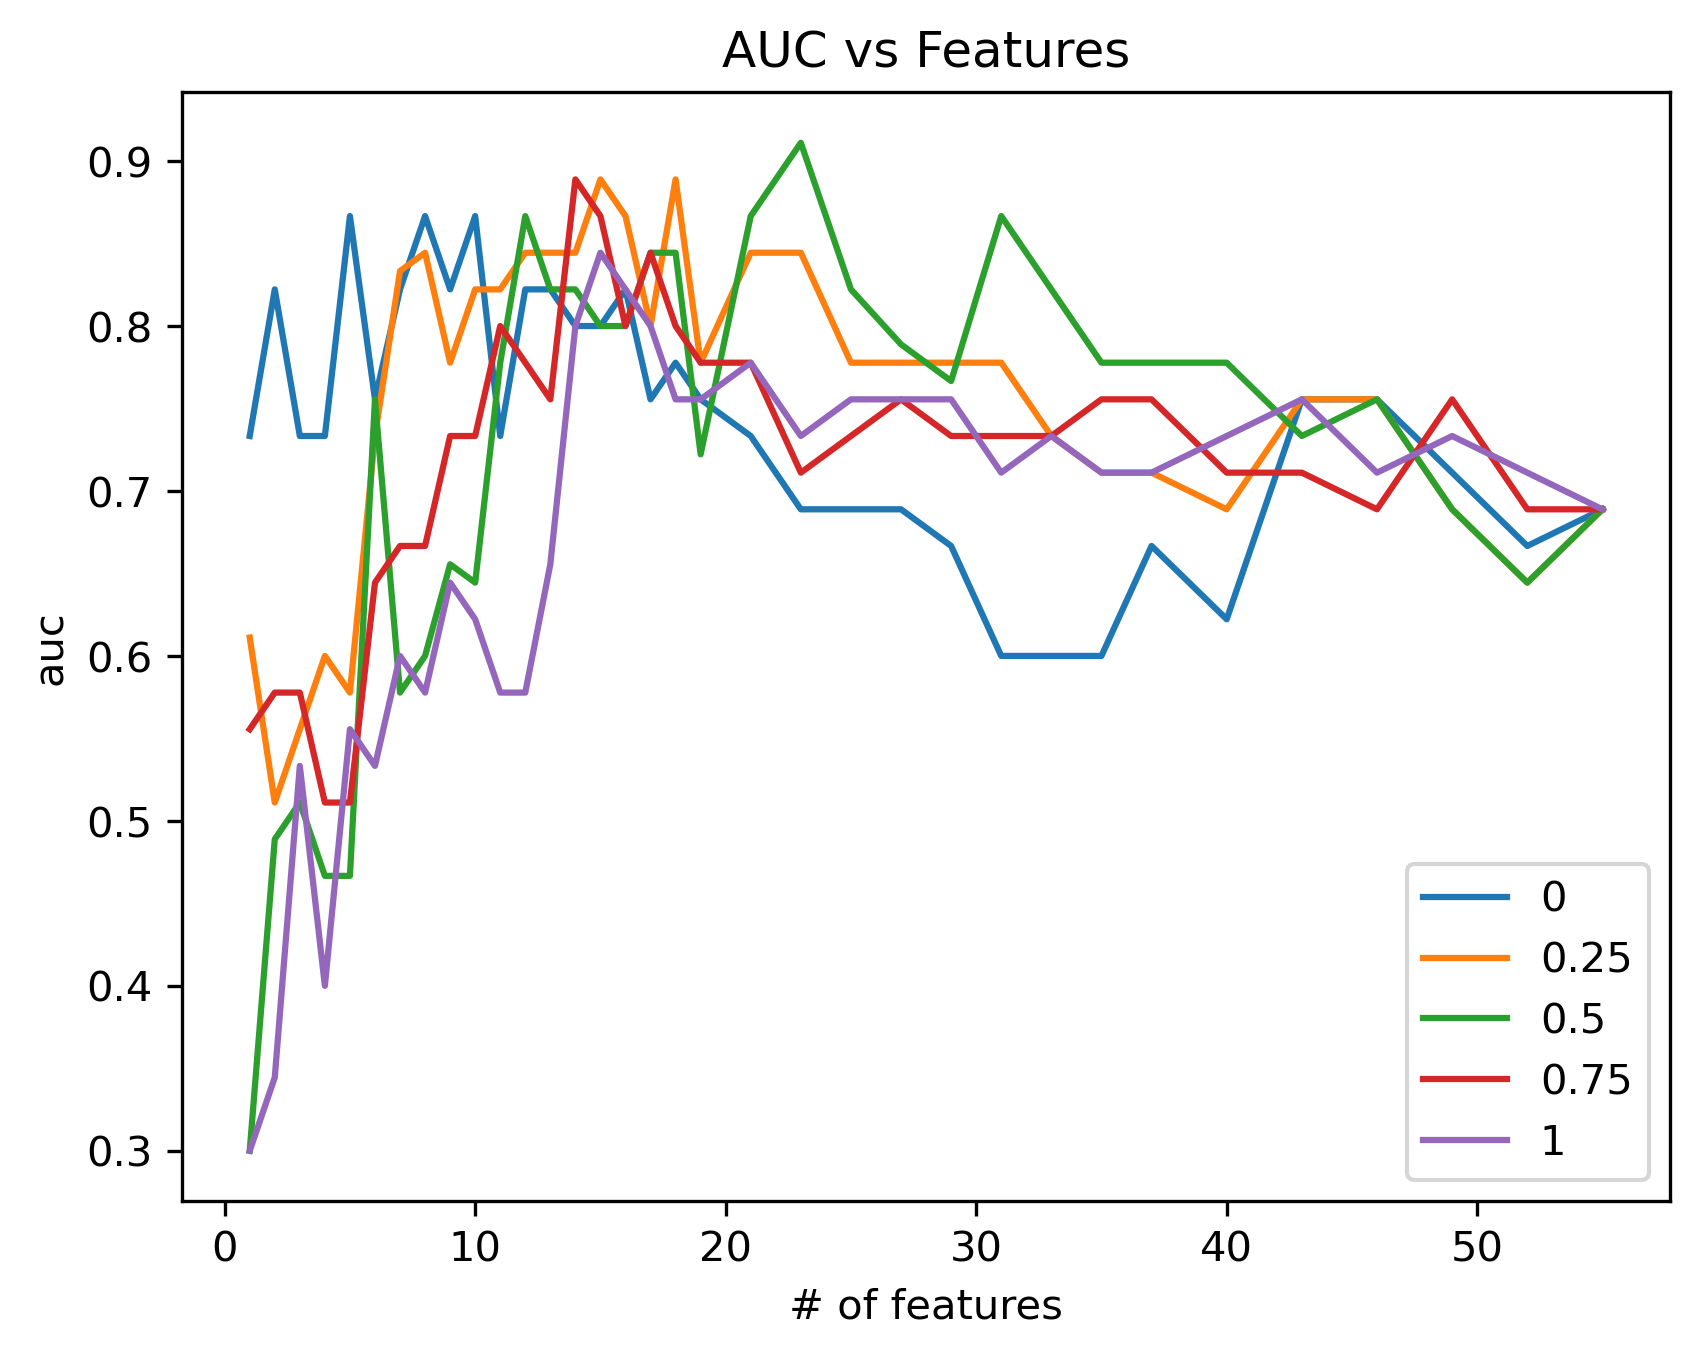

In [16]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="auc")

plt.legend(labels=rank_weights)
ax.set_title("AUC vs Features")

#saving figure
figCommon = fileName_common + "_AUC"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

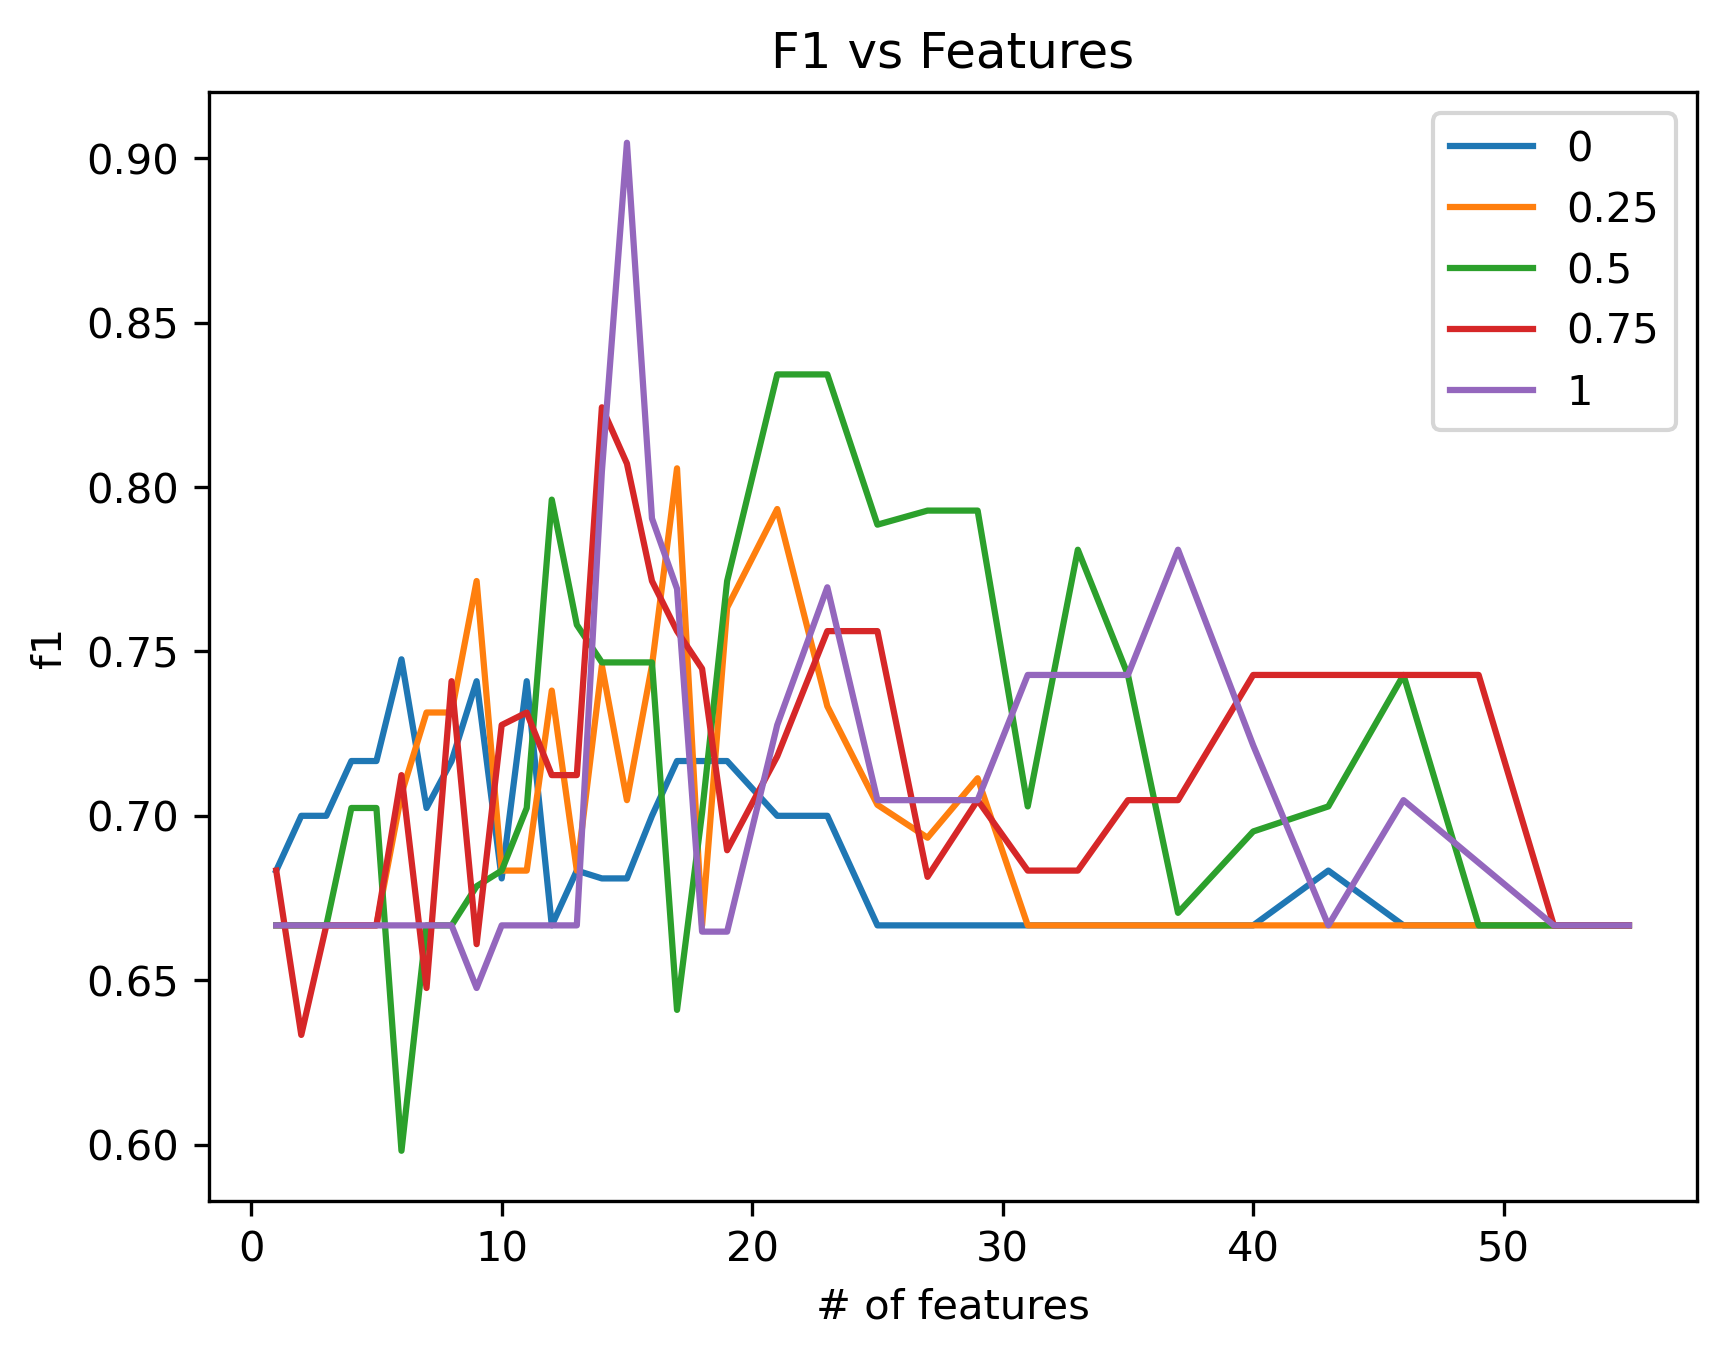

In [17]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="f1")

plt.legend(labels=rank_weights)
ax.set_title("F1 vs Features")

#saving figure
figCommon = fileName_common + "_F1"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

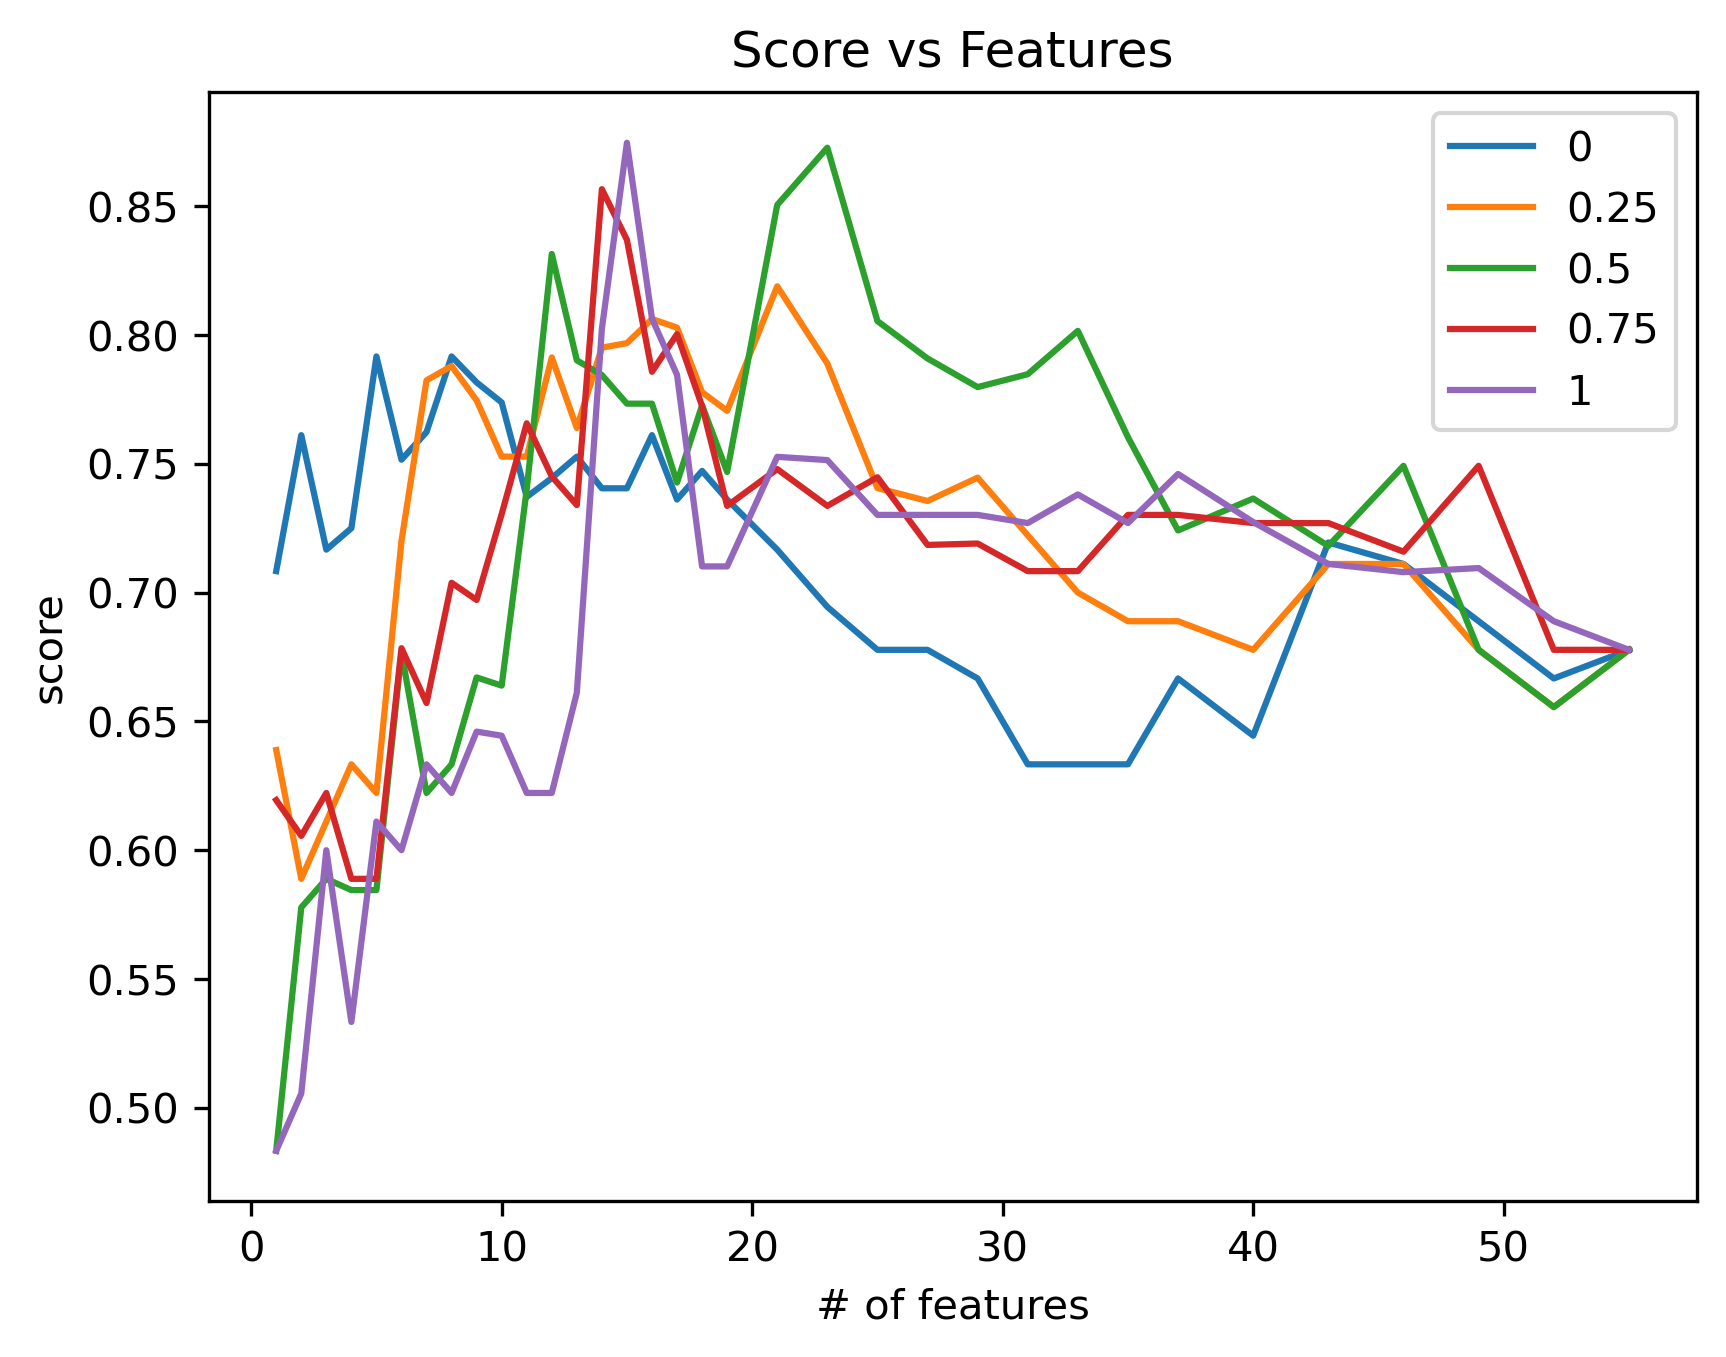

In [18]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="score")

plt.legend(labels=rank_weights)
ax.set_title("Score vs Features")

#saving figure
figCommon = fileName_common + "_Score"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

# picking best model 

In [19]:
enrich_score = []
for i in range(len(rank_weights)):
    enrich_score.append(svm_set_ranks[i].enrichment_score())

# selected_run = 4 
selected_run = enrich_score.index(max(enrich_score))

enrich_score

[0.6893665223665224,
 0.7082417027417026,
 0.7181688311688311,
 0.7060613275613276,
 0.6886565656565656]

In [20]:
# svm_set_ranks[selected_run].performance_.keys()

In [21]:
score_list = []

for i in range(len(rank_weights)):
    score_list.append(svm_set_ranks[i].performance_['score'])

maxScore = max(score_list)
topModelIndex = score_list.index(maxScore)


In [22]:
#saving the feature ranking, performance, and model evaluations to spreadsheets

for i in range(len(rank_weights)):
    #collecting the performance as a dataframe
    df_bestPerformance = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index')
    outputToExcel(df_data=df_bestPerformance, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
                folderName= dataFrameFolderOut, sheetName= str(rank_weights[i]).replace(".", "") + "_best model perf")


    df_bestFeatures= pd.DataFrame(list(X.columns[svm_set_ranks[i].features]))
    #saving the best features
    outputToExcel(df_data=df_bestFeatures, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
                folderName= dataFrameFolderOut, sheetName= str(rank_weights[i]).replace(".","") + "_features")




In [23]:
# for i in range(len(rank_weights)): 
#     # print("test")
#     print("weight " , str(rank_weights[i]) , " :" ,svm_set_ranks[i].performance_ , '\n')
#     print("features: ", "\n", list(X.columns[svm_set_ranks[i].features]), "\n")

In [24]:
iterator = 1
for i in range(len(rank_weights)):
    if iterator == 1:
        #create the df_performance and collect the performance information
        df_performance = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index', columns = [str(rank_weights[i])]).T

        #create feature list dataframe 
        df_features = pd.DataFrame(list(X.columns[svm_set_ranks[i].features]), columns=[str(rank_weights[i])])
        iterator = iterator + 1 #to increment
    else:
        #collect the data and add it to the existing frames
        df_temp_perf = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index', columns = [str(rank_weights[i])]).T
        df_temp_features = pd.DataFrame(list(X.columns[svm_set_ranks[i].features]), columns=[str(rank_weights[i])])
        #concatinate with pervious
        df_performance = pd.concat([df_performance, df_temp_perf], axis =0)
        df_features = pd.concat([df_features, df_temp_features], axis = 1)
        iterator = iterator + 1

#saving the features and performance
outputToExcel(df_data=df_performance, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_best model perf")

outputToExcel(df_data=df_features, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_features")

iterator = 1
dict_blindprediction = {} #index is the weight
for i in range(len(rank_weights)):
    decision_values = svm_set_ranks[i].decision_function(X_test)
    y_pred = svm_set_ranks[i].predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    specificity = tn/(tn + fp)
    f1 = 2*precision*recall/(precision+recall)
    auc = roc_auc_score(y_test, decision_values)

    dict_temp_blindpred = {"f1": f1, 'auc': auc, 'true neg': tn, 'false pos': fp, 'false neg': fn, 'true pos': tp,
                           'precision or PPV': precision, 'recall or TPR': recall, 'specificity or TNR': specificity}
    if iterator == 1:
        df_blindprediction = pd.DataFrame.from_dict(data = dict_temp_blindpred, orient = 'index', columns = [str(rank_weights[i])]).T
        iterator = iterator +1
    else:
        df_temp_blindpred = pd.DataFrame.from_dict(data = dict_temp_blindpred, orient = 'index', columns = [str(rank_weights[i])]).T
        df_blindprediction = pd.concat([df_blindprediction, df_temp_blindpred], axis = 0)
        iterator = iterator + 1
    # print(df_temp_blindpred)
    # dict_blindprediction[str(rank_weights[i])] = df_temp_blindpred

# df_blindprediction = pd.DataFrame.from_dict(dict_blindprediction, orient= 'index')
outputToExcel(df_data=df_blindprediction, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_blindprediction")


In [25]:
df_performance

f1       auc     score     C     gamma  num_features  mean_nSV
0     0.716667  0.866667  0.791667   2.0  0.007812           5.0      29.0
0.25  0.793333  0.844444  0.818889   8.0  0.015625          21.0      24.8
0.5   0.834286  0.911111  0.872698  16.0  0.062500          23.0      25.8
0.75  0.824286  0.888889  0.856587   8.0  0.250000          14.0      27.4
1     0.904762  0.844444  0.874603  16.0  0.031250          15.0      26.2

In [26]:
df_blindprediction

f1    auc  true neg  false pos  false neg  true pos  \
0     0.545455  0.425       1.0        4.0        1.0       3.0   
0.25  0.666667  1.000       5.0        0.0        2.0       2.0   
0.5   0.666667  0.600       5.0        0.0        2.0       2.0   
0.75  0.500000  0.800       3.0        2.0        2.0       2.0   
1     0.666667  0.550       5.0        0.0        2.0       2.0   

      precision or PPV  recall or TPR  specificity or TNR  
0             0.428571           0.75                 0.2  
0.25          1.000000           0.50                 1.0  
0.5           1.000000           0.50                 1.0  
0.75          0.500000           0.50                 0.6  
1             1.000000           0.50                 1.0

In [27]:
df_features

0                                     0.25  \
0   Beta-2-Microglobulin Result                                   HemeTx   
1             Hemoglobin Result                            HemeTx Number   
2                   MCHC Result           Albumin Electrophoresis Result   
3                    MCV Result              Beta-2-Microglobulin Result   
4              Pct. Mono Result                 Creatinine Result(mg/dL)   
5                           NaN                               HCT Result   
6                           NaN                        Hemoglobin Result   
7                           NaN    Kappa Free Light Chains Result (mg/L)   
8                           NaN                          LDH Result(U/L)   
9                           NaN                           MCH Result(pg)   
10                          NaN                              MCHC Result   
11                          NaN                               MCV Result   
12                          NaN                     Nucleated RBC Result   
13                          NaN                         Pct. Mono Result   
14                          NaN                               RBC Result   
15                          NaN     Serum Electrophoresis Alpha 1 Result   
16                          NaN     Serum Electrophoresis Alpha 2 Result   
17                          NaN        Serum Electrophoresis Beta Result   
18                          NaN       Serum Electrophoresis Gamma Result   
19                          NaN                         WBC Result(k/uL)   
20                          NaN  NT Pro BNP (B-Type Natriuretic Peptide)   
21                          NaN                                      NaN   
22                          NaN                                      NaN   

                                        0.5  \
0                      Survival (in months)   
1                           ImmunoTx Number   
2                                     RadTx   
3                              RadTx Number   
4                                   OtherTx   
5                            OtherTx Number   
6                             RelTime(Days)   
7            Albumin Electrophoresis Result   
8                     Albumin Result(gm/dL)   
9                         BUN Result(mg/dL)   
10                  Chloride Result(mmol/L)   
11                               HCT Result   
12                          LDH Result(U/L)   
13                              MCHC Result   
14                               MCV Result   
15                          Monocyte Result   
16                     Nucleated RBC Result   
17     Serum Electrophoresis Alpha 2 Result   
18        Serum Electrophoresis Beta Result   
19       Serum Electrophoresis Gamma Result   
20               Total Serum Protein Result   
21                         total CO2 Result   
22  NT Pro BNP (B-Type Natriuretic Peptide)   

                                       0.75  \
0                      Survival (in months)   
1                           ImmunoTx Number   
2                                     RadTx   
3                             RelTime(Days)   
4                     Albumin Result(gm/dL)   
5                         BUN Result(mg/dL)   
6                           LDH Result(U/L)   
7                           Monocyte Result   
8               Platelet Count Result(k/uL)   
9                                RBC Result   
10        Serum Electrophoresis Beta Result   
11               Total Serum Protein Result   
12                         total CO2 Result   
13  NT Pro BNP (B-Type Natriuretic Peptide)   
14                                      NaN   
15                                      NaN   
16                                      NaN   
17                                      NaN   
18                                      NaN   
19                                      NaN   
20                                      NaN   
21                                      Na

# plots for best model

## pair plots

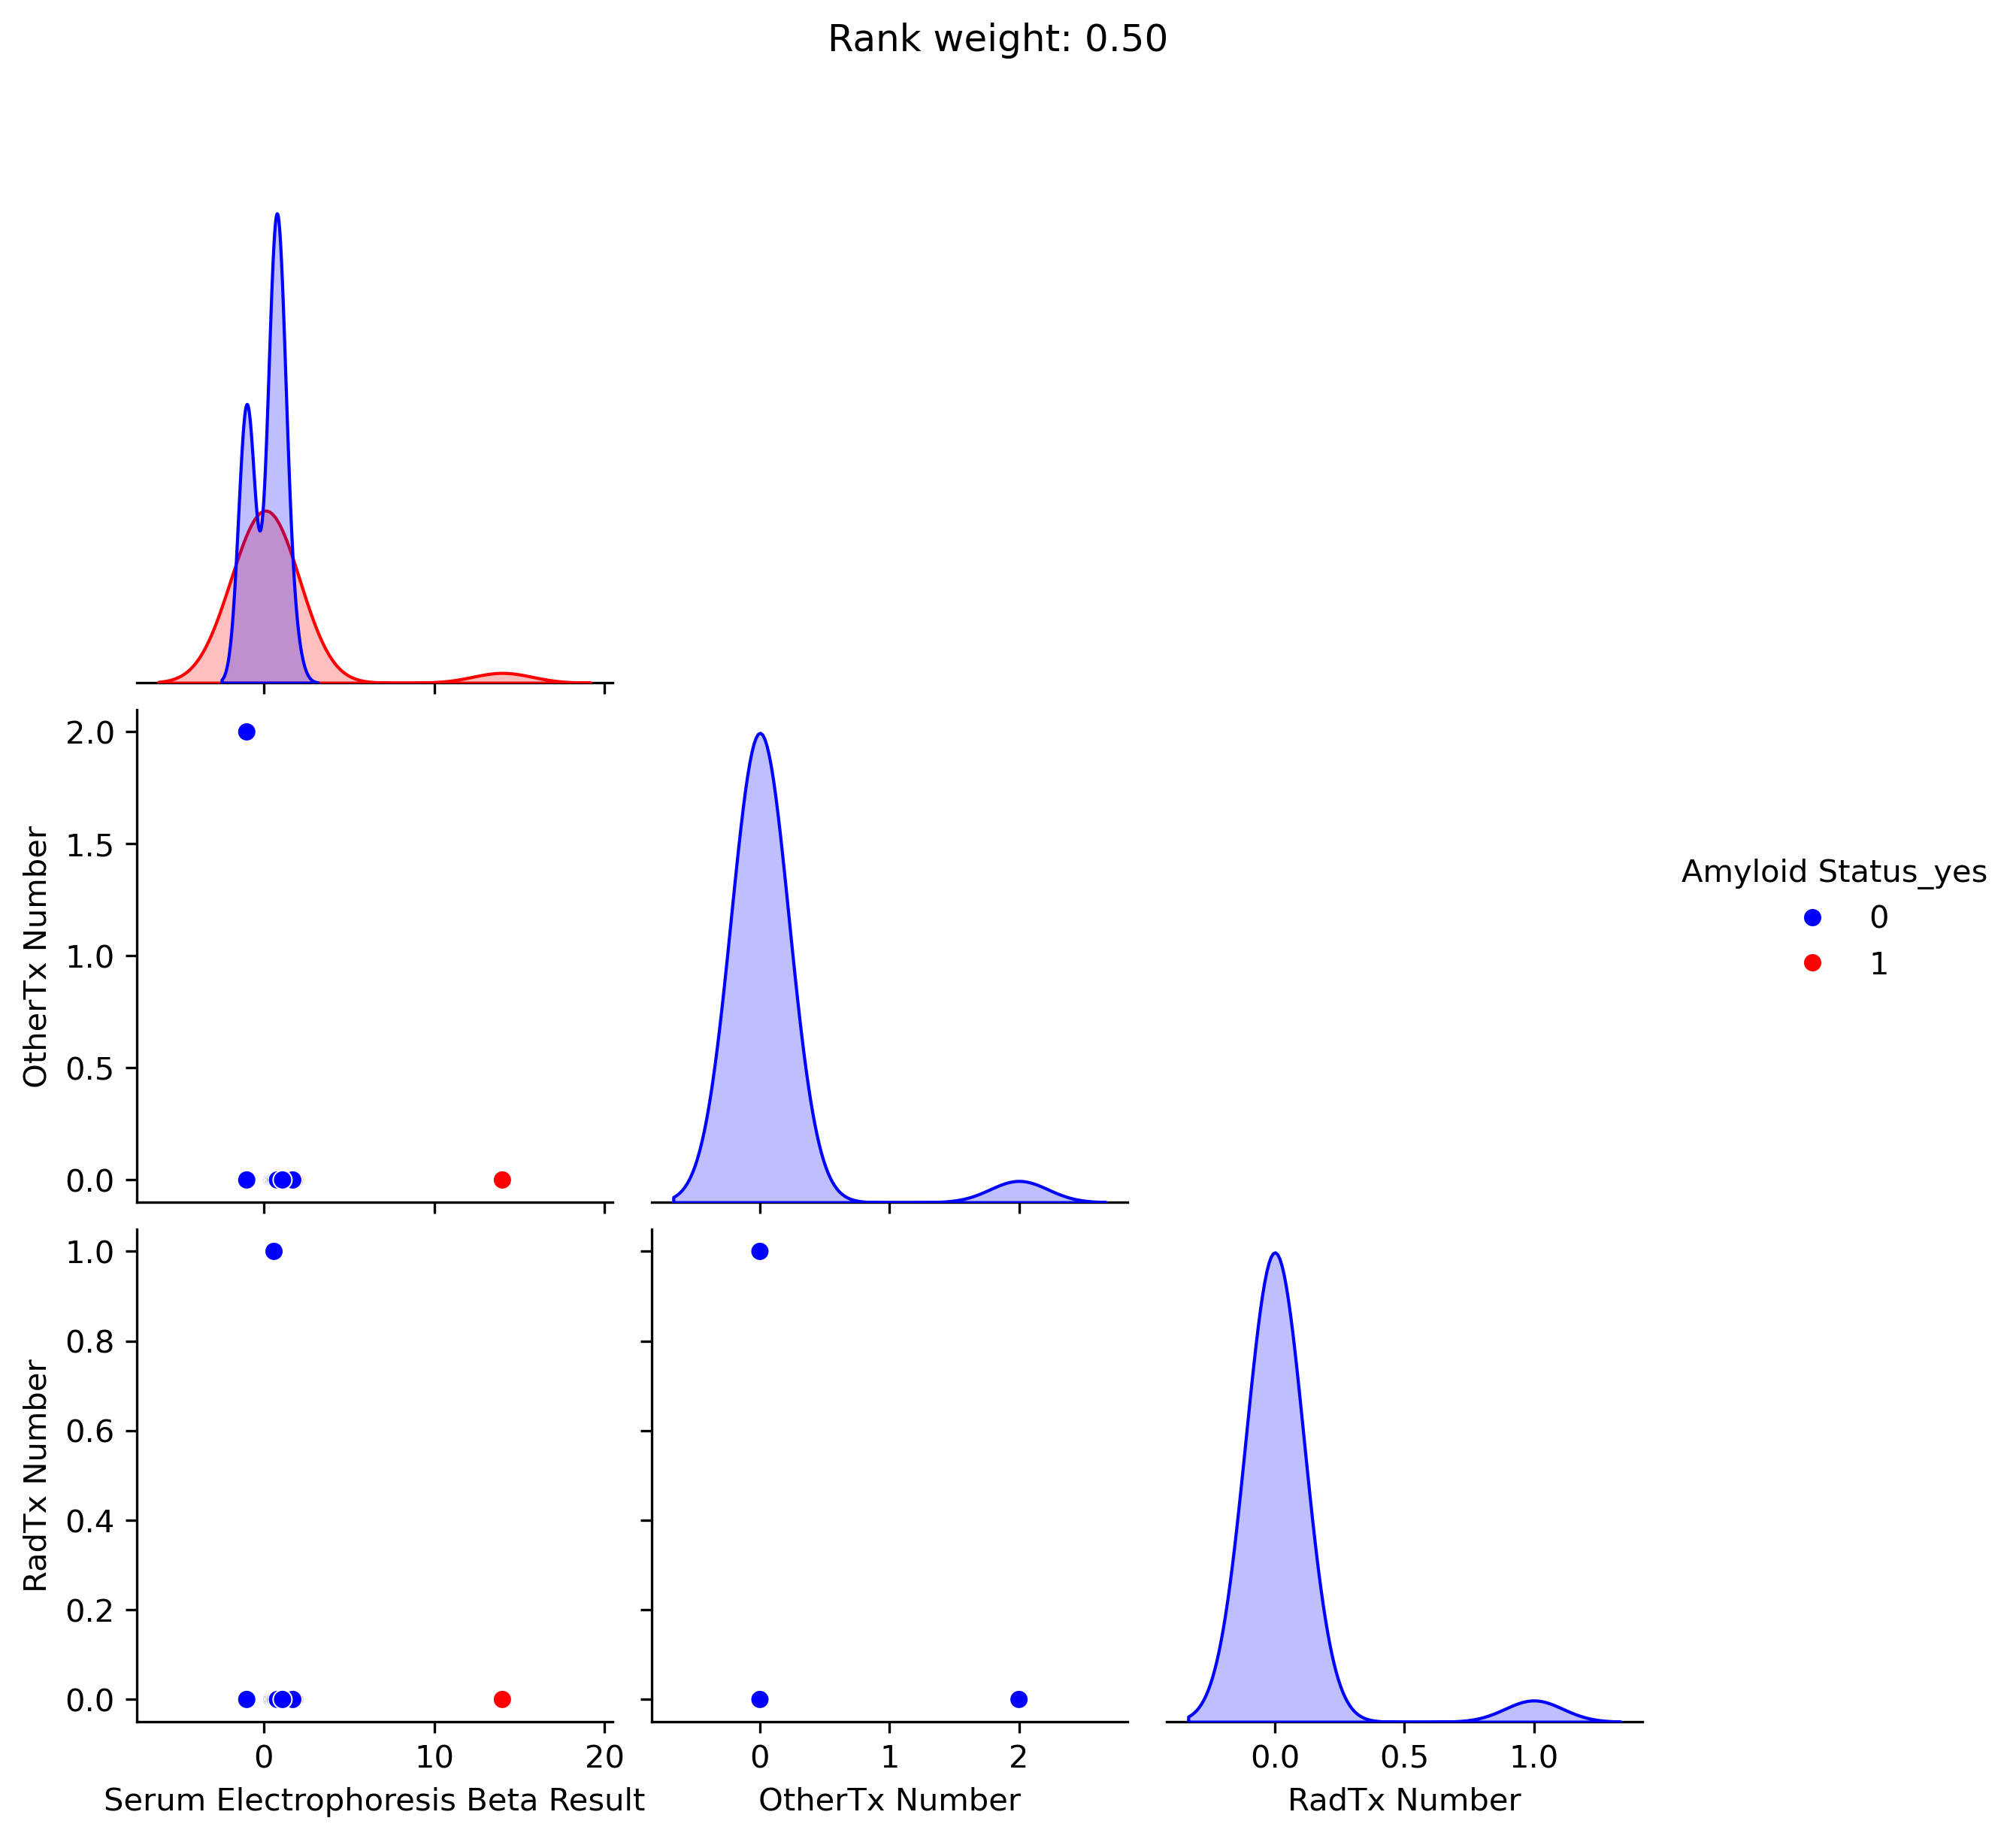

In [28]:
import plotly.express as px
from seaborn import pairplot, clustermap, load_dataset
# fig, ax = plt.subplots()

palette = {np.int64(1) :'red', np.int64(0): 'blue'} #our data is of int64

# selected_model = 0
top_features = X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[0:3]].values
fig = pairplot(dataTable[np.append(top_features, y_column_Classification)],
         hue=y_column_Classification, corner=True, palette=palette)
fig.fig.suptitle(f"Rank weight: {rank_weights[selected_run]:.2f}", y=1.08)

#saving figure
figCommon = fileName_common + str(rank_weights[selected_run]).replace(".", "") + "_pairplot"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

## 3D scatter

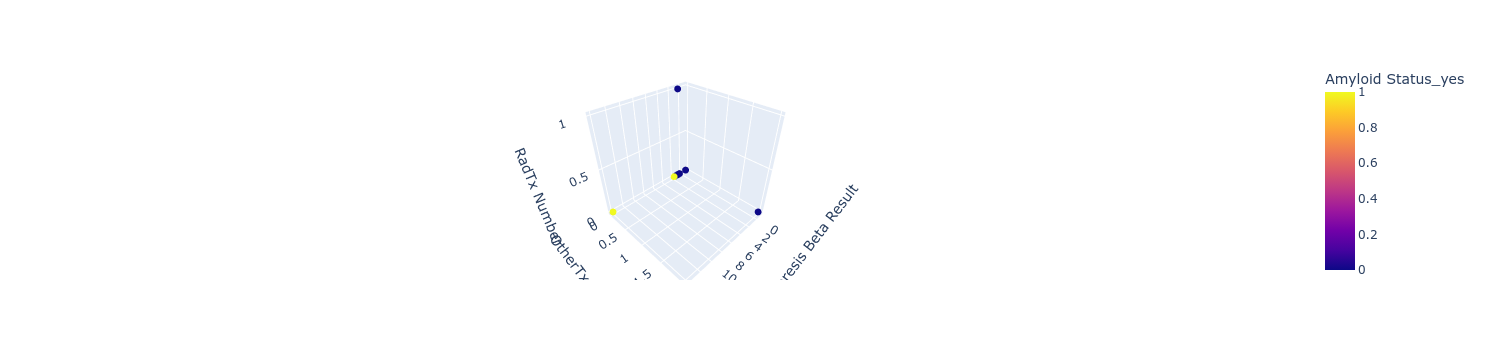

In [29]:
fig = px.scatter_3d(dataTable, x=top_features[0], y=top_features[1], z=top_features[2],
          color=y_column_Classification)
fig.update_traces(marker_size = 4)
fig.show()

## integrated gradients attribution

/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma/mistic/utility.py:223: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



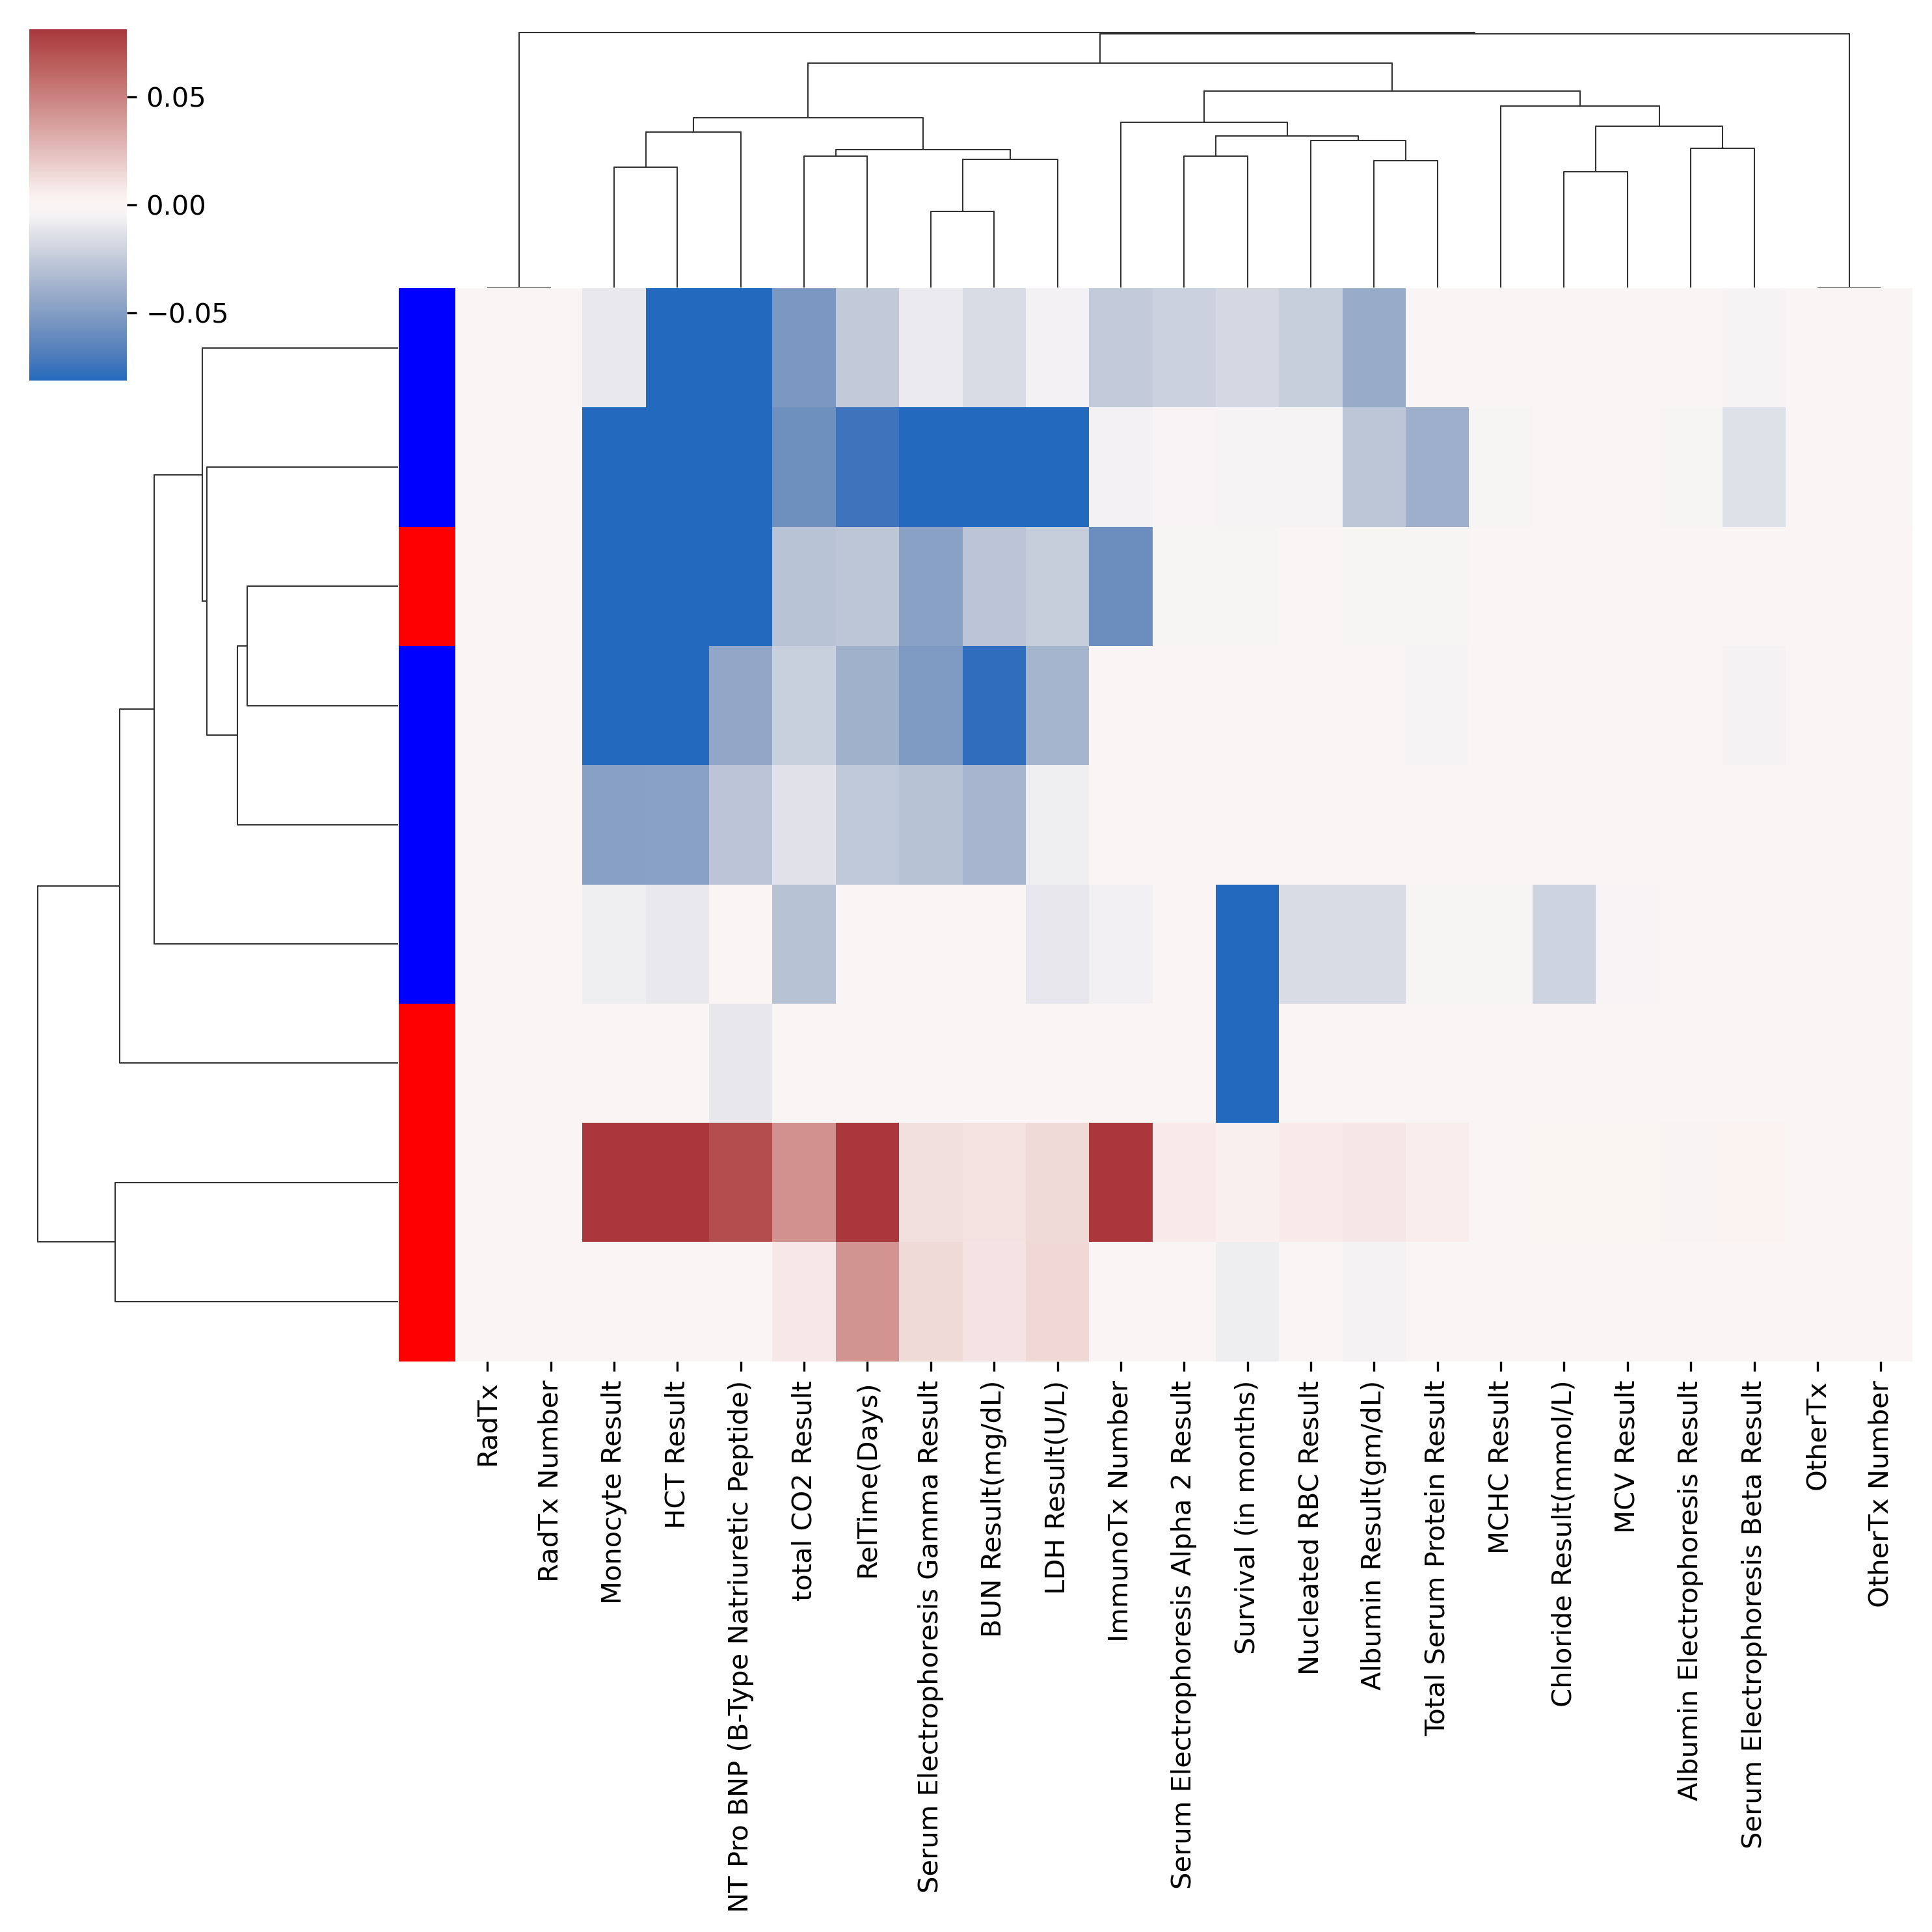

In [30]:
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster

linkMeth = "average"

IG = svm_set_ranks[selected_run].integrated_gradient(X_test)

IGtable = pd.DataFrame(IG,columns=X.columns[svm_set_ranks[selected_run].features])

distMatCol = perDiff(IGtable)
hcCol = linkage(distMatCol, method=linkMeth,optimal_ordering=True)

tr_IGtable = IGtable.transpose()
distMatRow = perDiff(tr_IGtable)
hcRow = linkage(distMatRow, method=linkMeth,optimal_ordering=True)

color_val = max(np.abs((np.mean(IG)-np.std(IG), np.mean(IG)+np.std(IG))))

#fig, ax = plt.subplots()
fig = clustermap(IGtable, 
           yticklabels=False,
           cmap="vlag", vmin=-color_val, vmax=color_val,
           row_linkage=hcRow, col_linkage=hcCol, 
           row_colors=[["red","blue"][int(l==np.int64(0))+0] for l in y_test])

#saving figure
figCommon = fileName_common + str(rank_weights[selected_run]).replace(".", "") + "_IGheatmap"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# plt.tight_layout()
fig.savefig(figPath, bbox_inches = 'tight')

In [31]:
# from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster

# linkMeth = "average"

# IG = svm_set_ranks[selected_run].integrated_gradient(X_all)

# IGtable = pd.DataFrame(IG,columns=X.columns[svm_set_ranks[selected_run].features])

# distMatCol = perDiff(IGtable)
# hcCol = linkage(distMatCol, method=linkMeth,optimal_ordering=True)

# tr_IGtable = IGtable.transpose()
# distMatRow = perDiff(tr_IGtable)
# hcRow = linkage(distMatRow, method=linkMeth,optimal_ordering=True)

# color_val = max(np.abs((np.mean(IG)-np.std(IG), np.mean(IG)+np.std(IG))))

# #fig, ax = plt.subplots()
# fig = clustermap(IGtable, 
#            yticklabels=False,
#            cmap="vlag", vmin=-color_val, vmax=color_val,
#            row_linkage=hcRow, col_linkage=hcCol, 
#            row_colors=[["red","blue"][int(l==np.int64(0))+0] for l in y_test])

# #saving figure
# figCommon = fileName_common + str(rank_weights[selected_run]).replace(".", "") + "_Xall_IGheatmap"
# figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# # plt.tight_layout()
# fig.savefig(figPath, bbox_inches = 'tight')

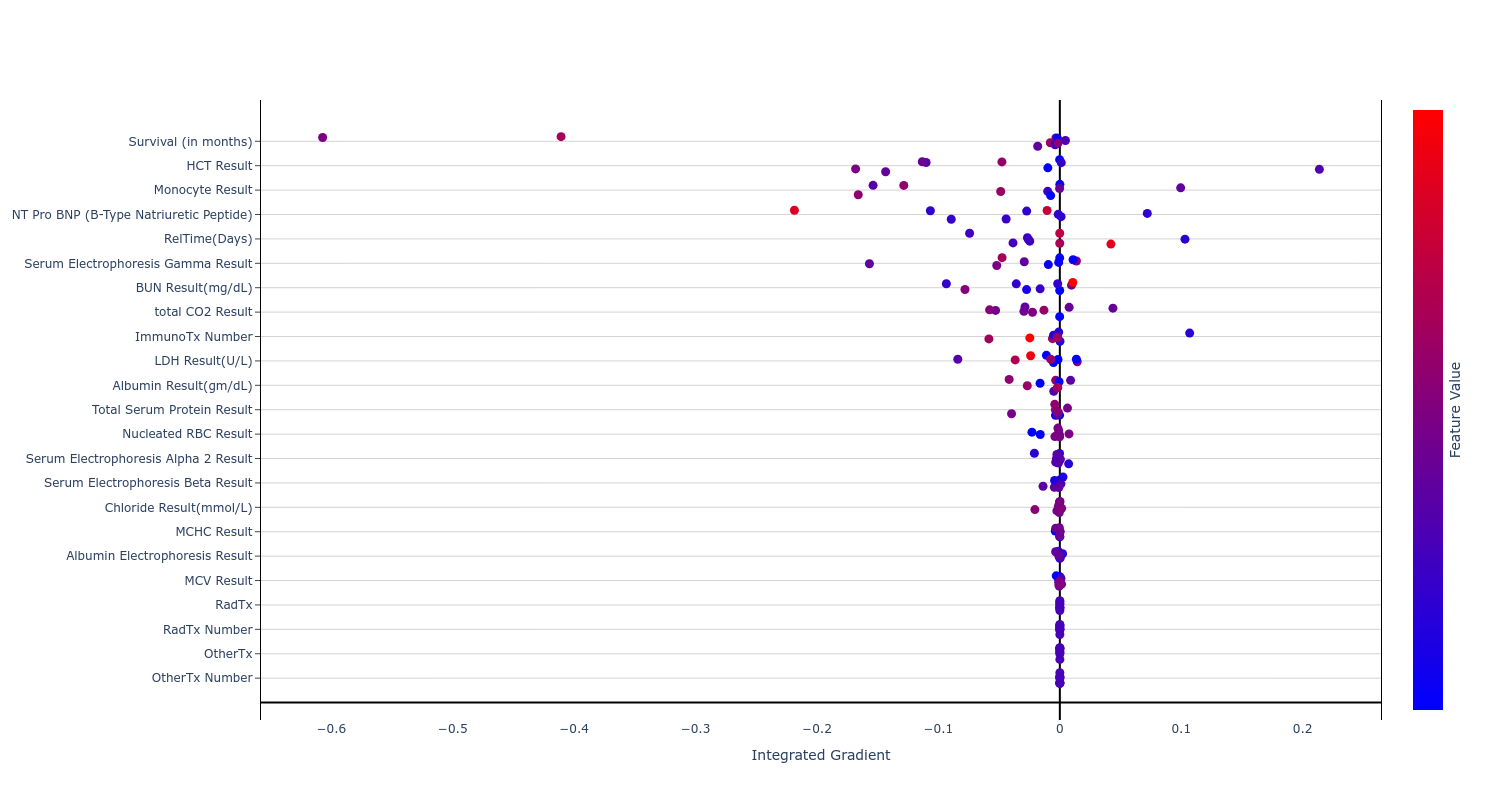

In [32]:
import plotly.graph_objects as go
import plotly.express as px
import numpy as np

features = svm_set_ranks[selected_run].features
df_X_test = pd.DataFrame(X_test[:,features],columns = IGtable.columns)
N = len(IGtable)

fig = go.Figure()
fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=800,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = "Integrated Gradient",
)

fig.update_xaxes(
    zeroline=True,
    zerolinecolor="black",
    )
    
fig.update_yaxes(
    zeroline=True,
    zerolinecolor="black",
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

feature_order = np.argsort(np.sum(abs(IG),axis=0))

y_val = 1
for f in feature_order:
    fig.add_trace(go.Scatter(
        x = IGtable.iloc[:,f], 
        y = y_val + np.random.rand(N)*0.5 - 0.25,
        mode = 'markers',
        marker = dict(size=9,
                      color = df_X_test.iloc[:,f],
                      coloraxis = "coloraxis",
                     ),
        name=IGtable.columns[f],
    ))
    y_val += 1


fig.update_layout(showlegend=False, coloraxis_showscale=True)
fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text="Feature Value",side = "right"),
                    cmin = -1, cmax = 2)
fig.update_yaxes(tickvals=[i for i in range(1,IGtable.shape[1]+1)], ticktext=IGtable.columns[feature_order])
fig.show() 

# #saving figure
# figCommon = fileName_common + str(selected_run) + "_attribution"
# figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# # plt.tight_layout()
# fig.savefig(figPath, bbox_inches = 'tight')

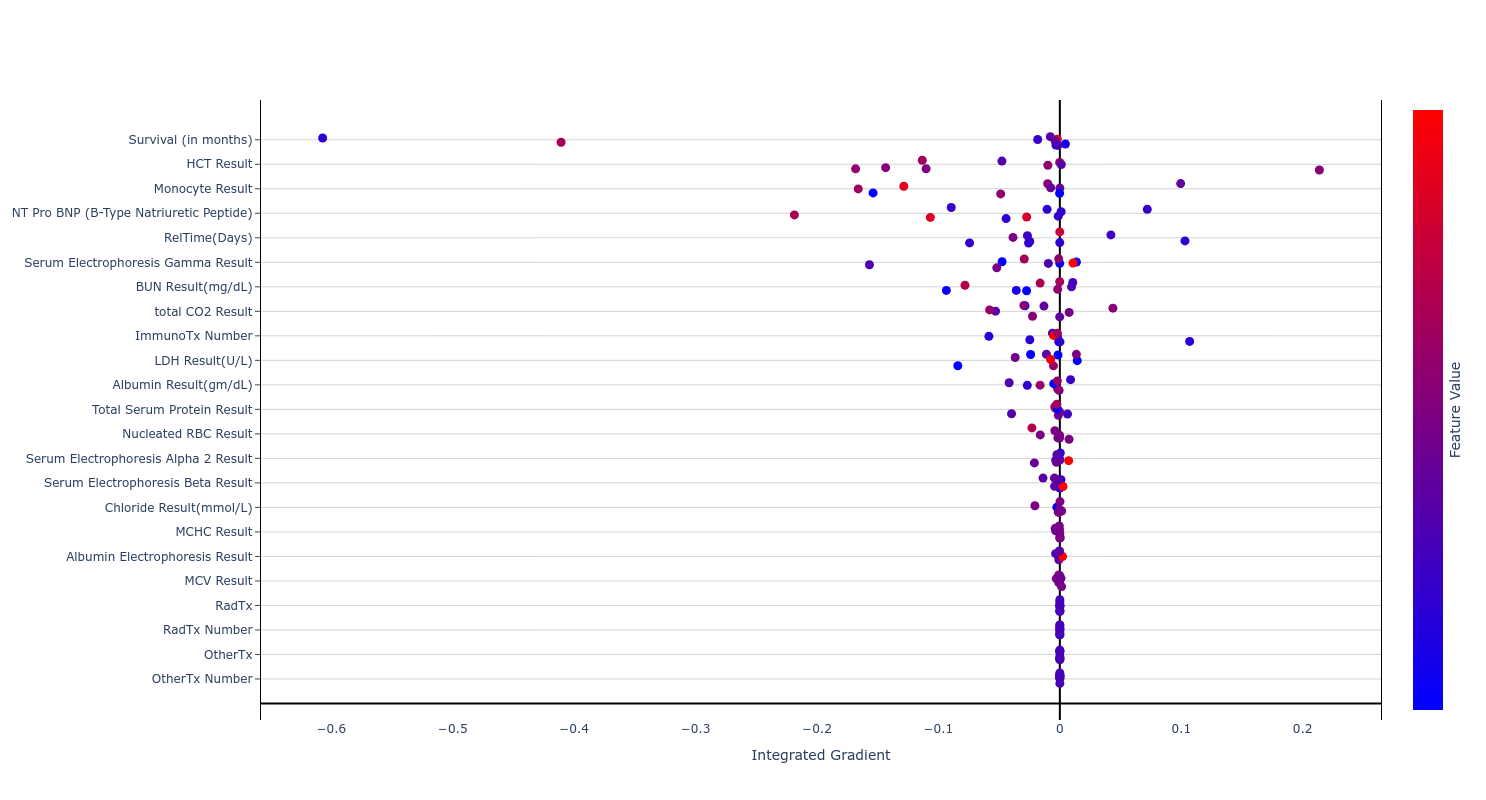

In [33]:
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import numpy as np

features = svm_set_ranks[selected_run].features
df_X_all = pd.DataFrame(X_all[:,features],columns = IGtable.columns)
N = len(IGtable)

fig = go.Figure()
fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=800,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = "Integrated Gradient",
)

fig.update_xaxes(
    zeroline=True,
    zerolinecolor="black",
    )
    
fig.update_yaxes(
    zeroline=True,
    zerolinecolor="black",
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

feature_order = np.argsort(np.sum(abs(IG),axis=0))

y_val = 1
for f in feature_order:
    fig.add_trace(go.Scatter(
        x = IGtable.iloc[:,f], 
        y = y_val + np.random.rand(N)*0.5 - 0.25,
        mode = 'markers',
        marker = dict(size=9,
                      color = df_X_all.iloc[:,f],
                      coloraxis = "coloraxis",
                     ),
        name=IGtable.columns[f],
    ))
    y_val += 1


fig.update_layout(showlegend=False, coloraxis_showscale=True)
fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text="Feature Value",side = "right"),
                    cmin = -1, cmax = 2)
fig.update_yaxes(tickvals=[i for i in range(1,IGtable.shape[1]+1)], ticktext=IGtable.columns[feature_order])
fig.show() 

#saving figure
figCommon = fileName_common + str(rank_weights[selected_run]) + "_Xall_attribution"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# plt.tight_layout()
#fig.fig.savefig(figPath, bbox_inches = 'tight')
#pio.write_image(fig, figPath)
#fig.show()

## 2x2

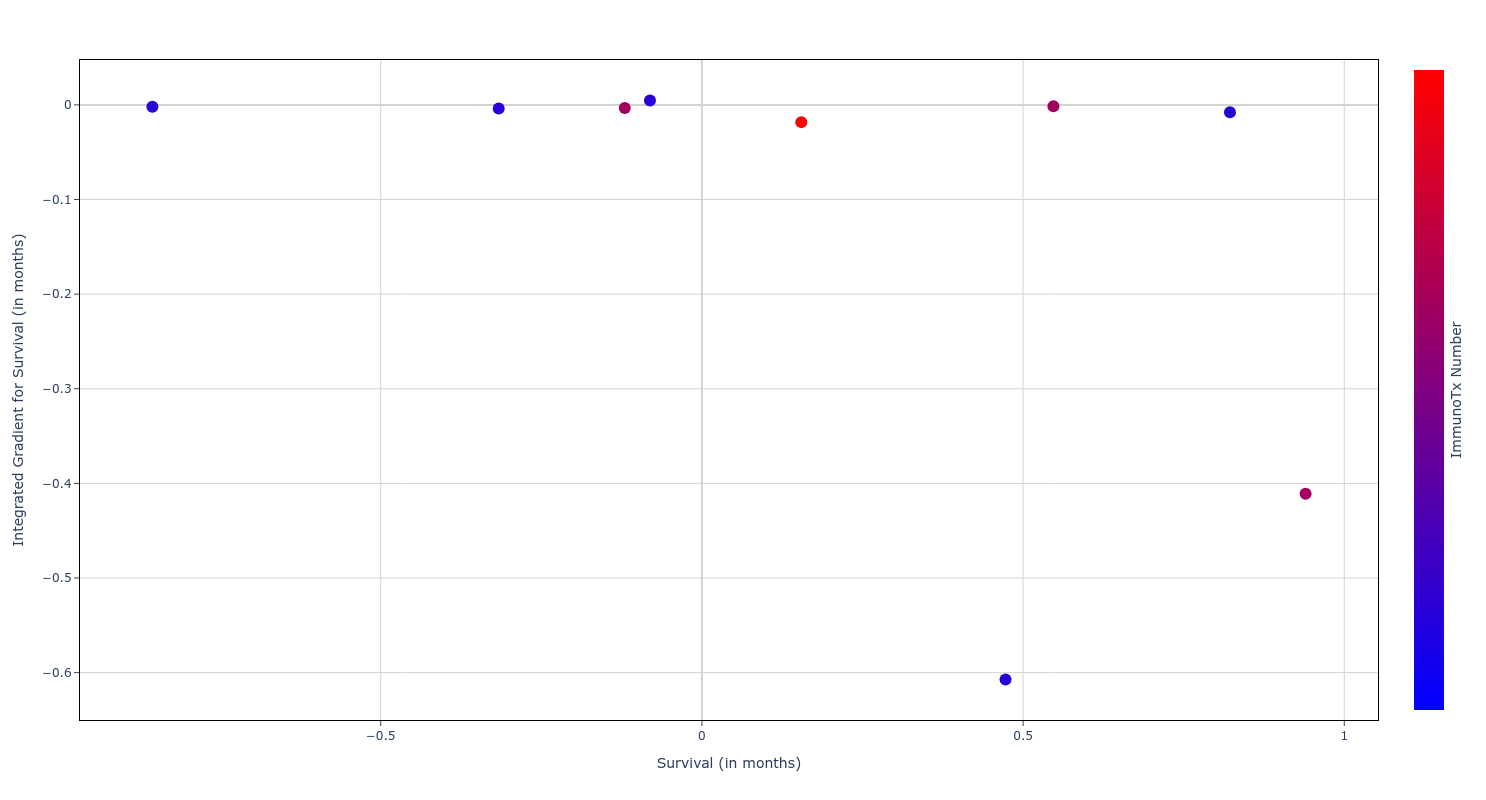

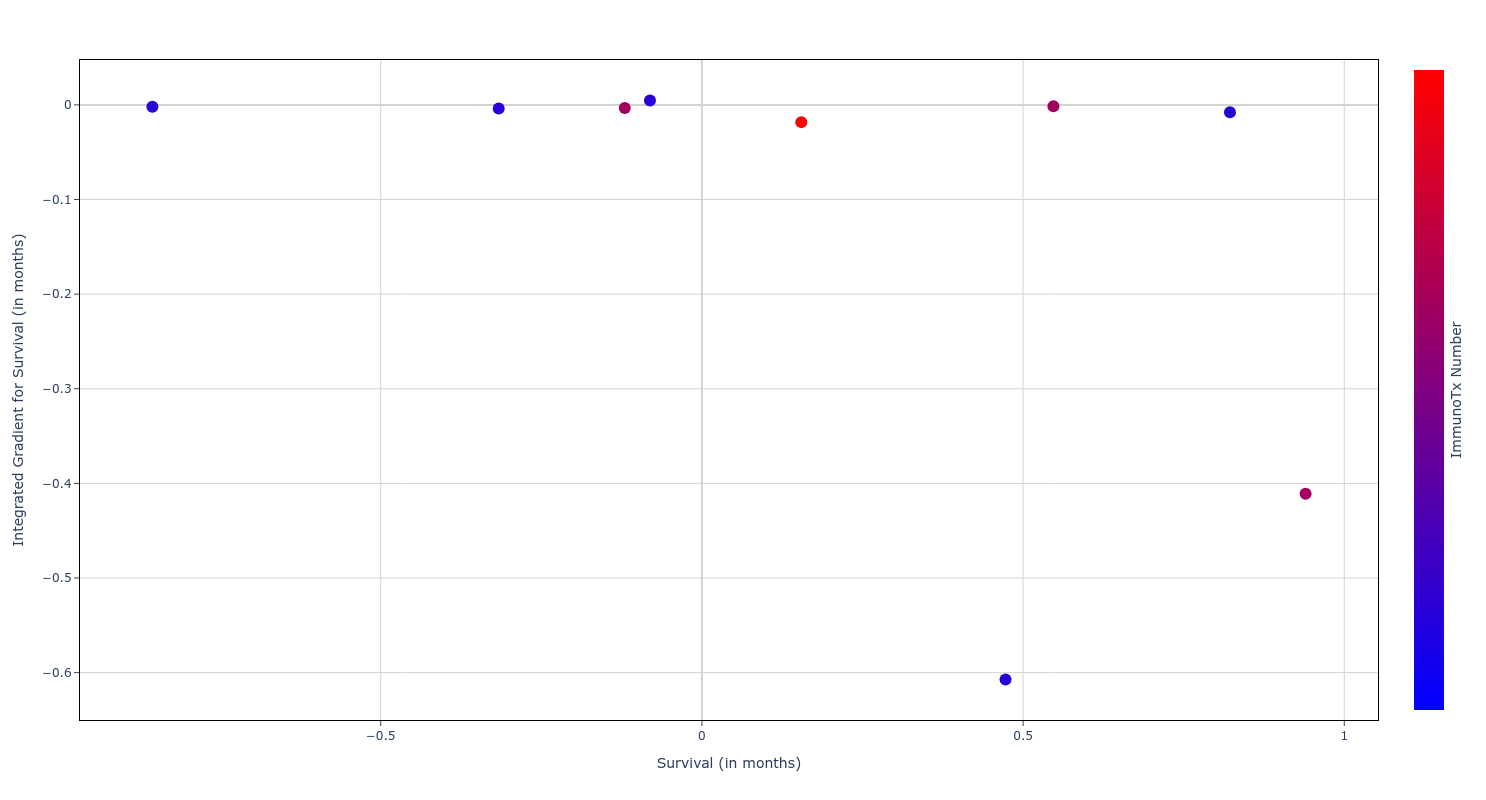

In [36]:
feat_1 = list(X.columns[svm_set_ranks[selected_run].features])[0]
feat_2 = list(X.columns[svm_set_ranks[selected_run].features])[1]

fig = px.scatter(x = df_X_test[feat_1], y = IGtable[feat_1], color = df_X_test[feat_2])
fig.update_traces(marker=dict(size=12))

fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=800,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = feat_1,
    yaxis_title = "Integrated Gradient for " + feat_1,
)

fig.update_xaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
    )
    
fig.update_yaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text=feat_2,side = "right"),
                    cmin = -1, cmax = 2)

fig.show()

figCommon = fileName_common + str(selected_run) + "_2x2"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# plt.tight_layout()
# fig.savefig(figPath, bbox_inches = 'tight')
fig.show()

In [35]:
feat_1 = list(X.columns[svm_set_ranks[selected_run].features])[0]
feat_2 = list(X.columns[svm_set_ranks[selected_run].features])[1]

fig = px.scatter(x = df_X_all[feat_1], y = IGtable[feat_1], color = df_X_all[feat_2])
fig.update_traces(marker=dict(size=12))

fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=800,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = feat_1,
    yaxis_title = "Integrated Gradient for " + feat_1,
)

fig.update_xaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
    )
    
fig.update_yaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text=feat_2,side = "right"),
                    cmin = -1, cmax = 2)

fig.show()

figCommon = fileName_common + str(selected_run) + "_Xall_2x2"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# plt.tight_layout()
# fig.savefig(figPath, bbox_inches = 'tight')
fig.show()

ValueError: All arguments should have the same length. The length of argument `y` is 9, whereas the length of  previously-processed arguments ['x'] is 44